# WeightWatcher demo (PyTorch)

In [1]:
# Requires PyTorch 0.4
import torch
import torchvision.models
import torch.nn as nn
from torchvision import datasets, transforms
from distutils.version import LooseVersion
assert LooseVersion(torch.__version__) >= LooseVersion("0.4")

import numpy as np

from ww import builder_pytorch, watcher

In [2]:
%load_ext autoreload
%autoreload 2

## Visualize Training Progress

In [3]:
# CIFAR10 Dataset
t = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('datasets', train=True, download=True, transform=t)
test_dataset = datasets.CIFAR10('datasets', train=False, download=True, transform=t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)

watcher.show("train_dataset.data", train_dataset.train_data)
watcher.show("train_dataset.labels", train_dataset.train_labels)
watcher.show("test_dataset.data", test_dataset.test_data)
watcher.show("test_dataset.labels", test_dataset.test_labels)

Files already downloaded and verified
Files already downloaded and verified
train_dataset.data	Tensor  uint8 (50000, 32, 32, 3)  min: 0.000  max: 255.000
train_dataset.labels	list    len: 50000  [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0]
test_dataset.data	Tensor  uint8 (10000, 32, 32, 3)  min: 0.000  max: 255.000
test_dataset.labels	list    len: 10000  [3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6]


In [4]:
# TODO: Moving model to GPU breaks grph drawing. Investigate
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Simple Convolutional Network
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AdaptiveMaxPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Linear(32, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CifarModel().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

e:\toolkits.win\anaconda3-5.1.0\envs\dlwin36torch\lib\site-packages\torch\onnx\utils.py:365: UserWarning: ONNX export failed on ATen operator adaptive_max_pool2d because torch.onnx.symbolic.adaptive_max_pool2d does not exist
  .format(op_name, op_name))


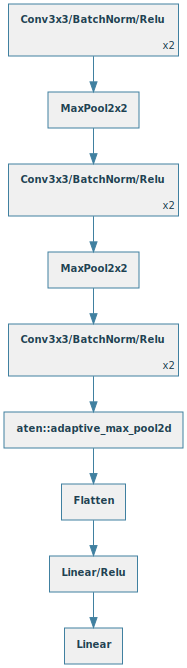

In [5]:
dg = builder_pytorch.build_pytorch_graph(model, torch.zeros([1, 3, 32, 32]), verbose=False)
dg.draw_graph_html(simplify=True, output_shapes=False, verbose=False)

In [6]:
step = 0
w = watcher.Watcher()

# Visual customizations
w.legend={"loss": "Training Loss",
          "accuracy": "Training Accuracy"}

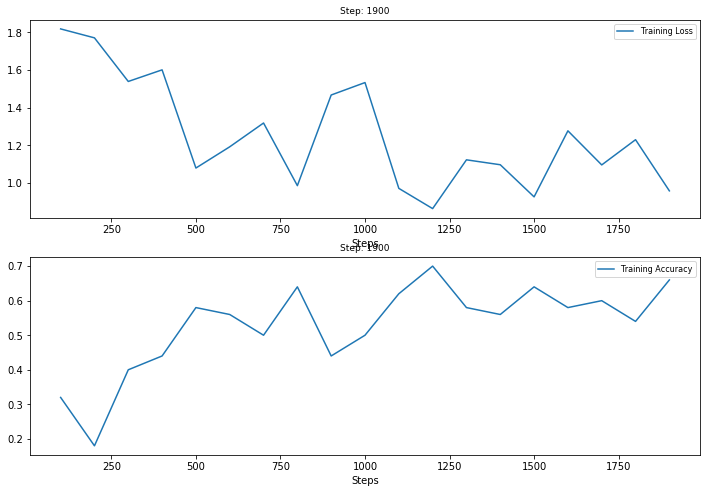

In [7]:
# Training loop
for epoch in range(2):
    train_iter = iter(train_loader)
    for inputs, labels in train_iter:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if step and step % 100 == 0:
            # Compute accuracy
            pred_labels = np.argmax(outputs.detach().numpy(), 1)
            accuracy = np.mean(pred_labels == labels.detach().numpy())
            
            w.step(step, loss=loss, accuracy=accuracy)
            with w:
                w.plot(["loss"])
                w.plot(["accuracy"])
        step += 1
